In [1]:
import pandas as pd

file_path = './filtered.csv'
df = pd.read_csv(file_path)

In [2]:
df = df.iloc[:,1:]

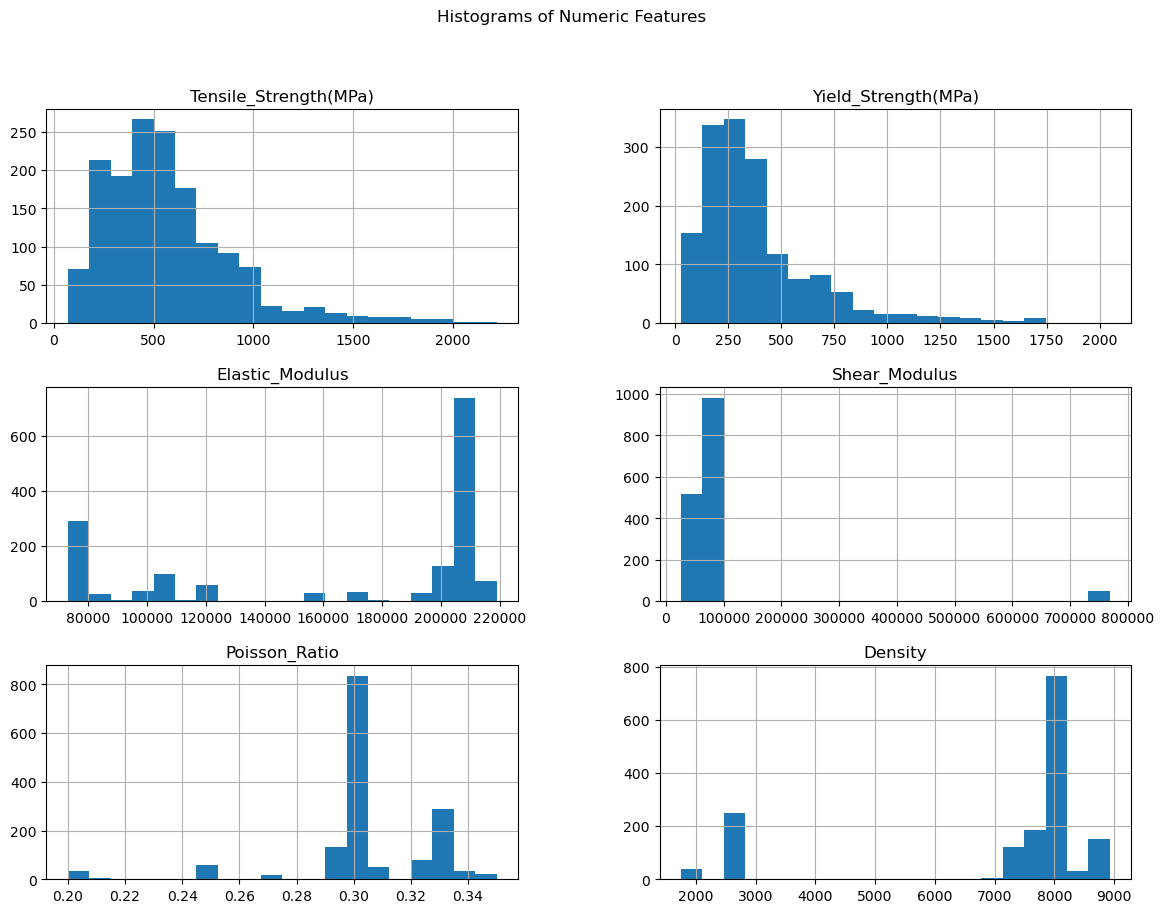

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot histograms
df.hist(bins=20, figsize=(14, 10))
plt.suptitle('Histograms of Numeric Features')
plt.show()

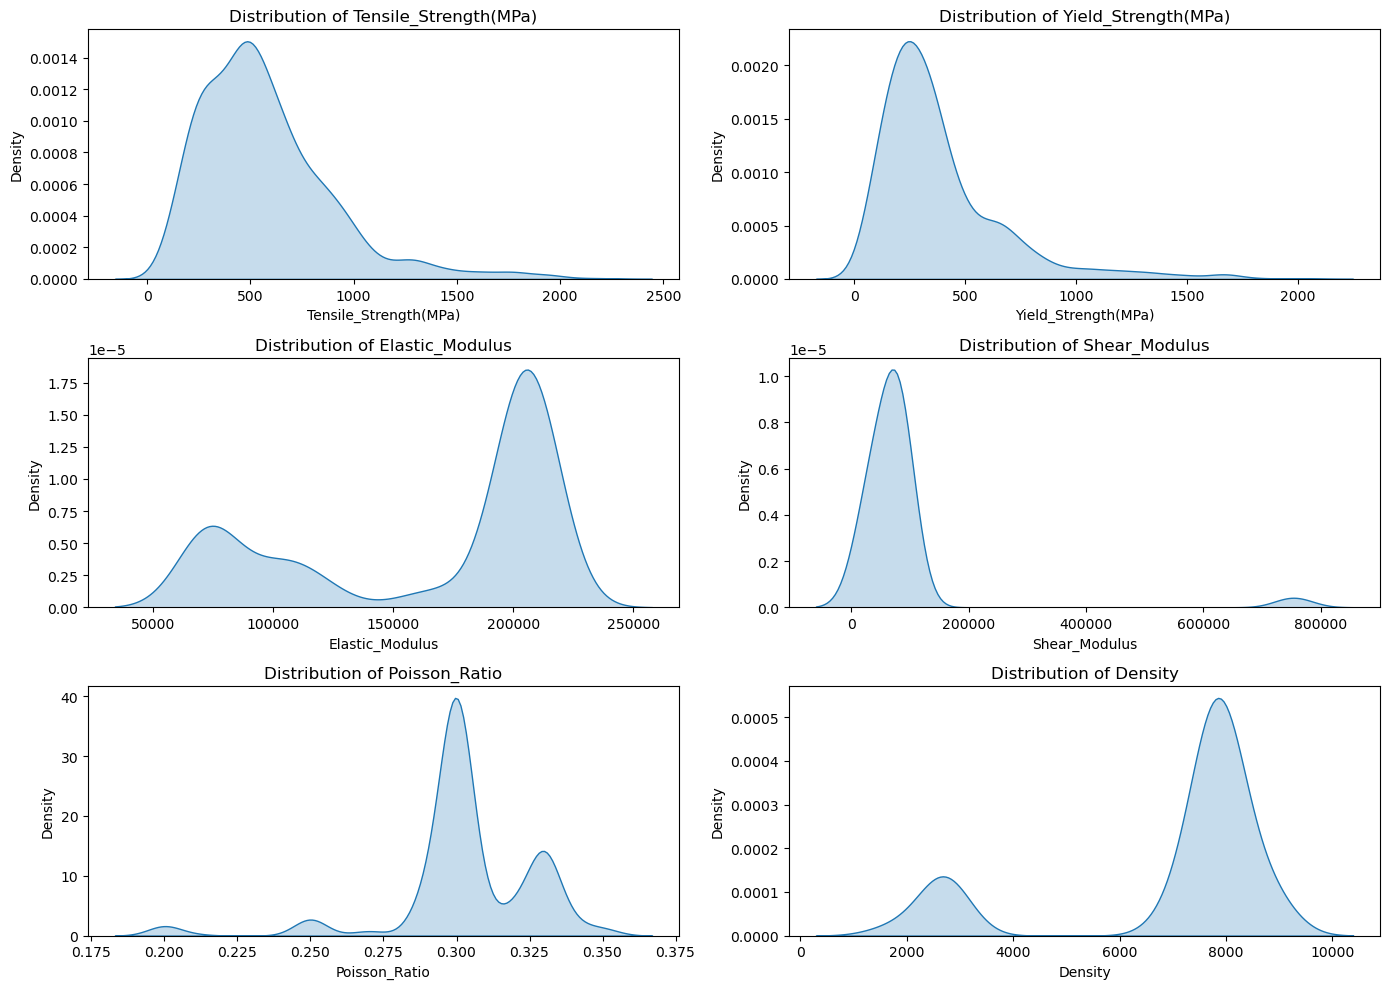

In [4]:
# KDE Plot
numeric_columns = ['Tensile_Strength(MPa)', 'Yield_Strength(MPa)', 'Elastic_Modulus',
                   'Shear_Modulus', 'Poisson_Ratio', 'Density']

plt.figure(figsize=(14, 10))
for i, col in enumerate(numeric_columns):
    plt.subplot(3, 2, i + 1)
    sns.kdeplot(df[col], fill=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

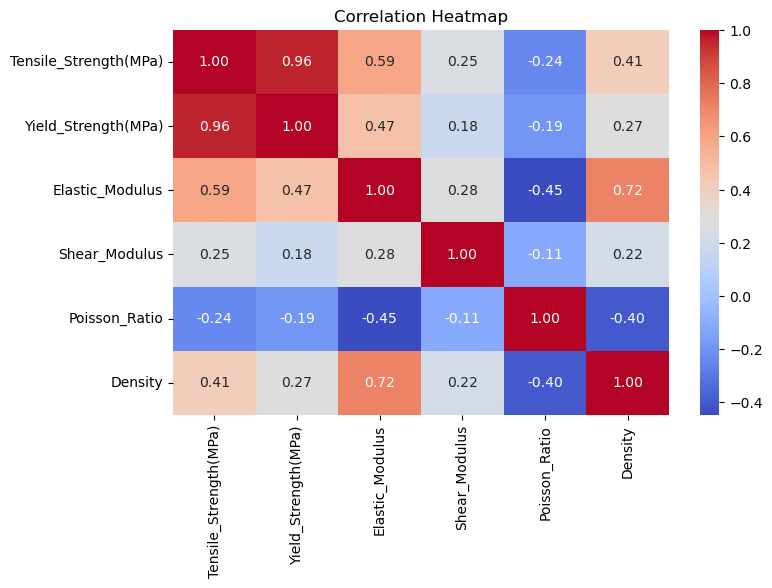

In [5]:
plt.figure(figsize=(8, 5))
corr = df[numeric_columns].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

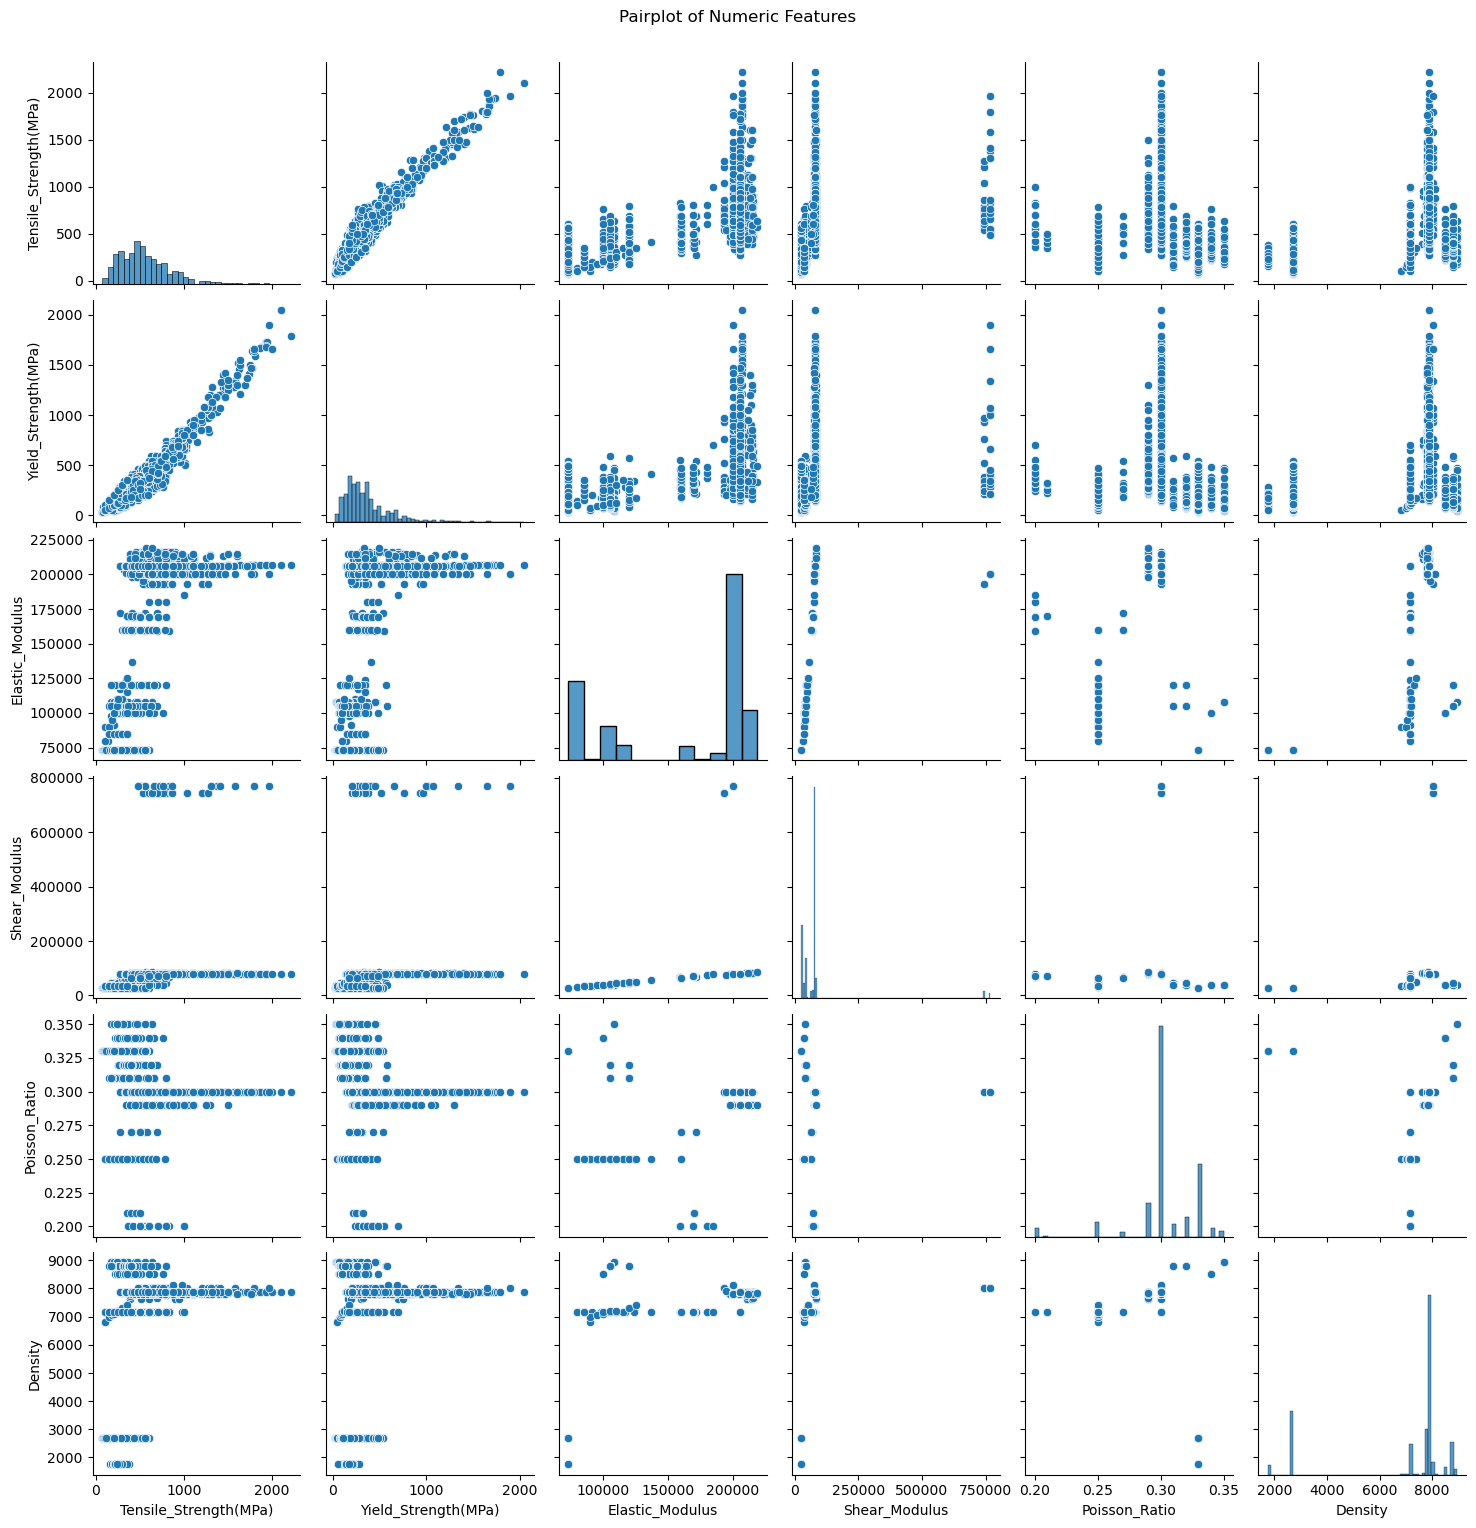

In [6]:
sns.pairplot(df[numeric_columns])
plt.suptitle('Pairplot of Numeric Features', y=1.02)
plt.show()

In [7]:
# Add the 'Annotation' column based on specific conditions
df['Annotation'] = (
    (df['Tensile_Strength(MPa)'].between(292, 683)) &
    (df['Yield_Strength(MPa)'].between(212, 494)) &
    (df['Elastic_Modulus'].between(196650, 217350)) &
    (df['Shear_Modulus'].between(47400, 110600)) &
    (df['Poisson_Ratio'].between(0.225, 0.375)) &
    (df['Density'].between(6288, 9432))
).map({True: 'Yes', False: 'No'})

In [8]:
df.head()

,Tensile_Strength(MPa),Yield_Strength(MPa),Elastic_Modulus,Shear_Modulus,Poisson_Ratio,Density,Annotation
0,421,314,207000,79000,0.3,7860,Yes
1,424,324,207000,79000,0.3,7860,Yes
2,386,284,207000,79000,0.3,7860,Yes
3,448,331,207000,79000,0.3,7860,Yes
4,441,346,207000,79000,0.3,7860,Yes


In [9]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

In [10]:
X = df.iloc[:,0:-1]
Y = df['Annotation']

In [11]:
dtc = DecisionTreeClassifier()
dtc.fit(X, Y)

DecisionTreeClassifier()

In [12]:
# Generate the graphviz representation of the decision tree
dot_data = export_graphviz(dtc, feature_names=X.columns, class_names=['No', 'Yes'], filled=True, rounded=True, out_file=None)

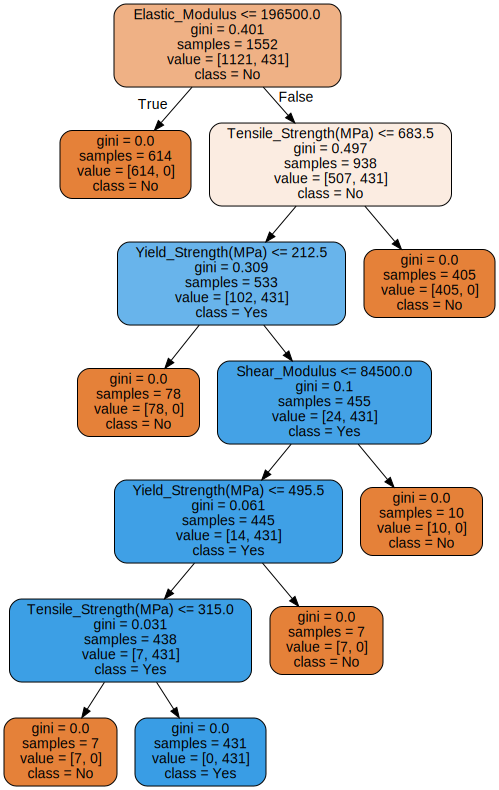

In [13]:
graph = graphviz.Source(dot_data, format='png')
graph

In [14]:
#Define the rating function 
#feature engineering
def get_rating(row):
    if (438.3 <= row['Tensile_Strength(MPa)'] <= 535.7 and
        318.6 <= row['Yield_Strength(MPa)'] <= 389.4 and
        204930 <= row['Elastic_Modulus'] <= 209070 and
        71100 <= row['Shear_Modulus'] <= 86900 and
        0.285 <= row['Poisson_Ratio'] <= 0.315 and
            7467 <= row['Density'] <= 8253):
        return 5
    elif (389.6 <= row['Tensile_Strength(MPa)'] <= 584.4 and
          283.2 <= row['Yield_Strength(MPa)'] <= 424.8 and
          202860 <= row['Elastic_Modulus'] <= 211140 and
          63200 <= row['Shear_Modulus'] <= 94800 and
          0.27 <= row['Poisson_Ratio'] <= 0.33 and
          7074 <= row['Density'] <= 8646):
        return 4
    elif (340.9 <= row['Tensile_Strength(MPa)'] <= 633.1 and
          247.8 <= row['Yield_Strength(MPa)'] <= 460.2 and
          200790 <= row['Elastic_Modulus'] <= 213210 and
          55300 <= row['Shear_Modulus'] <= 102700 and
          0.255 <= row['Poisson_Ratio'] <= 0.345 and
          6681 <= row['Density'] <= 9039):
        return 3
    elif (292.2 <= row['Tensile_Strength(MPa)'] <= 681.8 and
          212.4 <= row['Yield_Strength(MPa)'] <= 495.6 and
          198720 <= row['Elastic_Modulus'] <= 215280 and
          47400 <= row['Shear_Modulus'] <= 110600 and
          0.24 <= row['Poisson_Ratio'] <= 0.36 and
          6288 <= row['Density'] <= 9432):
        return 2
    else:
        return 1

In [15]:
df['rating'] = df.apply(get_rating, axis=1)
df.head(10)
df.to_csv("./dataWithTarget.csv", index=False)

In [16]:
# Separate the features and label columns
X = df.iloc[:, 0:-2].values
Y = df.iloc[:, -1].values

In [17]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [18]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, Y)

RandomForestClassifier(random_state=42)

In [19]:
new_material = np.array([430, 325, 207000, 79000, 0.3, 7860]).reshape(1, -1)
new_rating = rf.predict(new_material)
print("Predicted rating of the new material:", new_rating)

Predicted rating of the new material: [4]


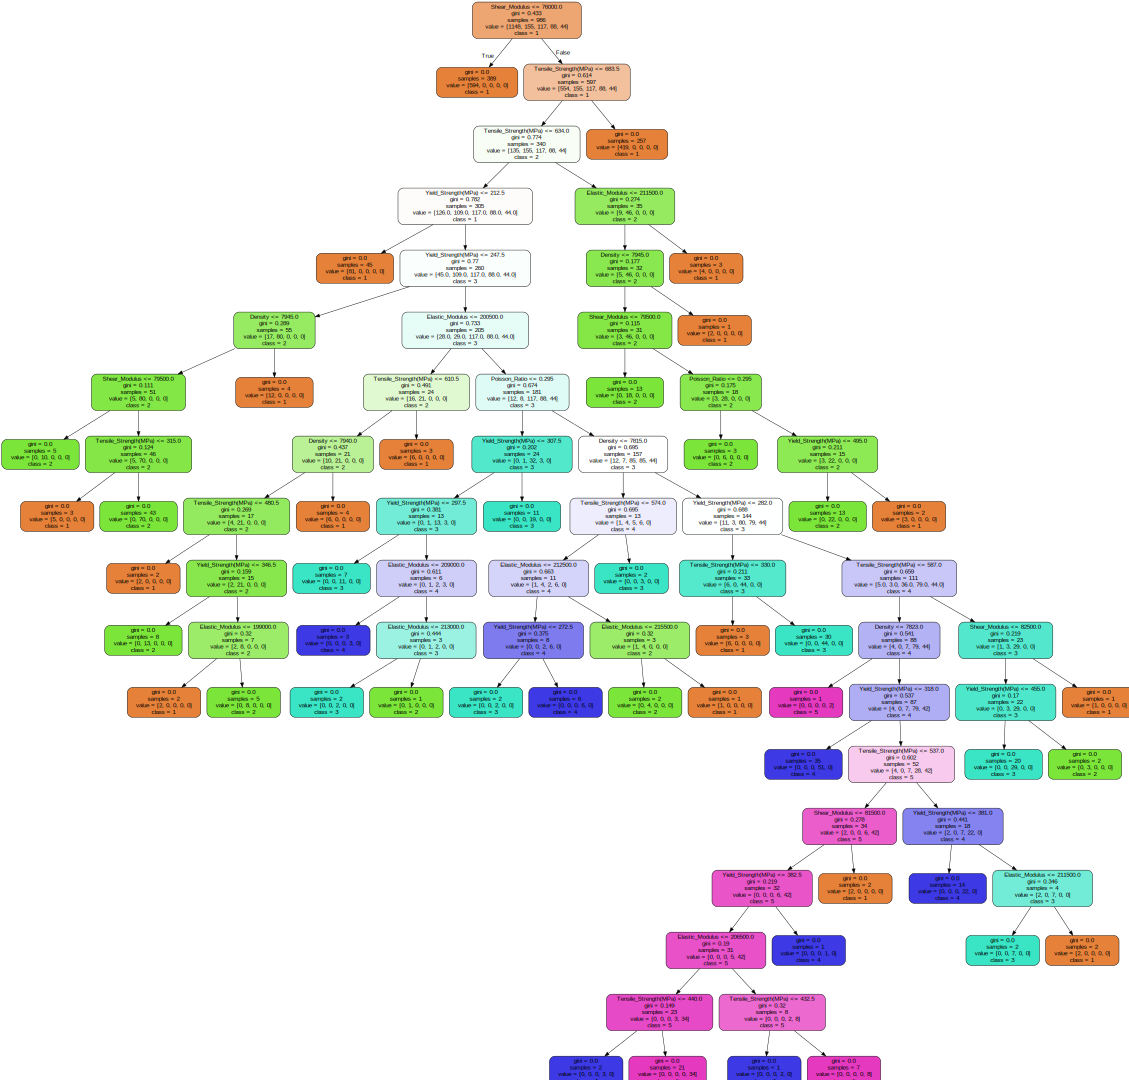

In [20]:
dot_data = export_graphviz(rf.estimators_[0], out_file=None, 
                           feature_names=['Tensile_Strength(MPa)', 'Yield_Strength(MPa)', 'Elastic_Modulus', 'Shear_Modulus', 'Poisson_Ratio', 'Density'],
                           class_names=['1', '2', '3', '4', '5'], 
                           filled=True, rounded=True)

# Customize graph attributes by appending directly to dot_data
dot_data = 'digraph Tree {\nsize="20,15!";\nranksep="0.8";\nnodesep="0.2";\n' + dot_data.split('\n', 1)[1]

# Generate and display the graph
graph = graphviz.Source(dot_data, format='png')
graph

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

***1. KNN Classification***

In [22]:
# Make predictions and evaluate
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9581993569131833


***2. Linear Regression***

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [24]:
y_pred = model.predict(X_test)
def rmpe(y_true, y_pred):
    percentage_error = np.abs((y_true - y_pred) / y_true) * 100
    mpe = np.mean(percentage_error)
    rmpe = np.sqrt(mpe)
    return rmpe

# Print RMPE
rmpe_value = rmpe(y_test, y_pred)
print("Root Mean Percentage Error:", rmpe_value)

Root Mean Percentage Error: 6.354934438686469


***3. Logistic regression***

In [25]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.7331189710610932


/home/abhishek/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


***4. Gradient Boosting (XGBoost)***

In [26]:
from xgboost import XGBClassifier

# Convert y to zero-indexed
y_train_adjusted = y_train - min(y_train)
y_test_adjusted = y_test - min(y_test)

# Initialize and train the XGBoost model
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train_adjusted)

# Predictions
y_pred_adjusted = xgb.predict(X_test)

# Reverse adjustments
y_pred = y_pred_adjusted + min(y_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9935691318327974


***5. Naive Bayes***

In [27]:
from sklearn.naive_bayes import GaussianNB

# Initialize and train the Naive Bayes model
nb = GaussianNB()
nb.fit(X_train, y_train)

# Predictions
y_pred = nb.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Naive Bayes Accuracy: {accuracy:.4f}")

Naive Bayes Accuracy: 0.7556


***6. AdaBoost***

In [28]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
ada = AdaBoostClassifier(n_estimators=50)  # Use default DecisionTreeClassifier as base estimator
ada.fit(X_train, y_train)

# Predictions
y_pred_ada = ada.predict(X_test)

# Accuracy
accuracy_ada = accuracy_score(y_test, y_pred_ada)
print(f"AdaBoost Accuracy: {accuracy_ada:.4f}")

/home/abhishek/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Accuracy: 0.8360


***7. LightGBM***

In [29]:
import lightgbm as lgb
# Initialize and train the LightGBM model
lgbm = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1)
lgbm.fit(X_train, y_train)

# Predictions
y_pred = lgbm.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"LightGBM Accuracy: {accuracy:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 1241, number of used features: 6
[LightGBM] [Info] Start training from score -0.320168
[LightGBM] [Info] Start training from score -2.256138
[LightGBM] [Info] Start training from score -2.498700
[LightGBM] [Info] Start training from score -2.889566
[LightGBM] [Info] Start training from score -3.460111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

***8. CatBoost***

In [30]:
from catboost import CatBoostClassifier
catboost = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=0)
catboost.fit(X_train, y_train)

# Predictions
y_pred = catboost.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"CatBoost Accuracy: {accuracy:.4f}")

CatBoost Accuracy: 0.9775


***9. Stochastic Gradient Descent (SGD)***

In [31]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris

# Load example data
data = load_iris()
X = data.data
y = data.target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the SGD model
sgd = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd.fit(X_train, y_train)

# Predictions
y_pred_sgd = sgd.predict(X_test)

# Accuracy
accuracy_sgd = accuracy_score(y_test, y_pred_sgd)
print(f"SGD Classifier Accuracy: {accuracy_sgd:.4f}")


SGD Classifier Accuracy: 0.6000


***Lasso***

In [32]:
# Import necessary libraries
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import make_regression


# Initialize the Lasso model with a regularization parameter (alpha)
alpha = 0.1  # Adjust alpha to control regularization strength
lasso_model = Lasso(alpha=alpha)

# Fit the model to the training data
lasso_model.fit(X_train, y_train)

# Predict on the test data
y_pred = lasso_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)
print("Lasso Coefficients:", lasso_model.coef_)


Mean Squared Error: 0.06677344873438026
R^2 Score: 0.9044577045136053
Lasso Coefficients: [ 0.         -0.          0.40782891  0.        ]


In [33]:
from sklearn.ensemble import RandomForestClassifier
from lime import lime_tabular

In [34]:
if 'Annotation' in df.columns and df['Annotation'].isna().sum() > 0:
    print(f"Missing values found in 'Annotation': {df['Annotation'].isna().sum()}")
    
    # Check if the mode is computable
    mode_series = df['Annotation'].mode()
    if not mode_series.empty:
        # Fill missing values with the mode
        most_frequent = mode_series.iloc[0]  # Access the first value of the mode
        df['Annotation'] = df['Annotation'].fillna(most_frequent)

df['Annotation'] = df['Annotation'].map({'Yes': 1, 'No': 0})
# df_filled = df.fillna(df.median(numeric_only = True))
# df_encoded = pd.get_dummies(df_filled, drop_first = True)

In [35]:
target_column = 'Annotation'
X = df.drop(columns = [target_column])
y = df[target_column]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [38]:
explainer = lime_tabular.LimeTabularExplainer(
X_train.values,
feature_names = X.columns,
class_names= ['Not Suitable', 'Suitable'],
mode = 'classification')

In [39]:
sample_idx = 0
sample = X_test.iloc[sample_idx].values.reshape(1, -1)

explanation = explainer.explain_instance(
sample[0],
model.predict_proba,
num_features = 10)


/home/abhishek/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [40]:
explanation.show_in_notebook()

In [43]:
from sklearn.preprocessing import StandardScaler

df['Strength_to_density'] = df['Tensile_Strength(MPa)']/df['Density']
scalar = StandardScaler()
numeric_features = ['Tensile_Strength(MPa)', 'Yield_Strength(MPa)', 'Elastic_Modulus', 'Shear_Modulus', 'Poisson_Ratio', 'Density']
df[numeric_features] = scalar.fit_transform(df[numeric_features])

X = df[numeric_features]
y = df['rating']